In [23]:
import numpy as np
from geometry import centroid, conjugate, translate, rotate, scale, complex2cart, cart2complex, PSI, PSI2

from penrose import RobinsonTriangle, FatRhombus, ThinRhombus, remove_dupes, make_svg, write_svg
from penrose import inflate, find_minmax, is_in_box
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
%load_ext autoreload
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from IPython.display import SVG, display
def show_svg(path:Path):
    display(SVG(path))

(608, 1080, 4)


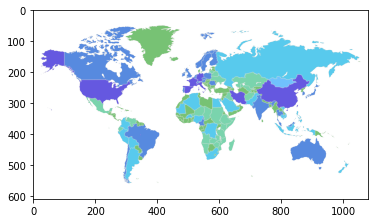

In [25]:
image = cv2.imread("map.png", cv2.IMREAD_UNCHANGED)
print(image.shape)
plt.imshow(image)
plt.show()

In [26]:
tile_scale = np.pi
scale = np.max(image.shape) * tile_scale
N = 6

theta = 2 * np.pi / 5
rot = np.cos(theta) + 1j * np.sin(theta)

a = -scale / 2 + 0j
b = scale / 2 * rot
c = scale / 2 / PSI + 0j

tri = FatRhombus((a, b, c))
tiling: list[RobinsonTriangle] = [tri]

# Inflate N times. Remove duplicates after each generation.
for _ in range(N):
    inflated = []
    for t in tiling:
        inflated.extend(inflate(t))
    tiling = inflated

tiling = remove_dupes(tiling)

# Add conjugate elements to reflect across the x axis
conj = [conjugate(t) for t in tiling]
tiling = remove_dupes(tiling + conj)


In [27]:
# Normalize the tiles
# Rotate so the tiles line up better with rectangular images.
theta = np.pi / 5.0
rot_tiles = [rotate(t, theta) for t in tiling]

minx, maxx, miny, maxy = find_minmax(rot_tiles)
# print(minx, maxx, miny, maxy)
x_amount = (minx + maxx) / -2
y_amount = (miny + maxy) / -2
amount = x_amount + y_amount

img_tiles = [translate(t, amount) for t in rot_tiles]

minx, maxx, miny, maxy = find_minmax(img_tiles)
print(minx, maxx, miny, maxy)


(-1372.46499692512-1495.7312826972698j) (2144.210160522717+879.4561022016763j) (-1286.9523317900832-1613.4293689604401j) (-285.7526095775446+997.1541884648468j)


In [28]:
stroke_width = str(PSI**N * scale * 0.01)

# Make svg
svg = make_svg(
    img_tiles,
    stroke_width=stroke_width
)
write_svg(svg, Path("all_tiles.svg"))
# show_svg(Path("foo.svg"))

In [29]:
# Translate tiles to be centered around the image's origin
amount = image.shape[1]/2.0 + 1j * image.shape[0]/2.0
shift_tiles = [translate(t, amount) for t in img_tiles]
minx, maxx, miny, maxy = find_minmax(shift_tiles)
# print(minx, maxx, miny, maxy)

42


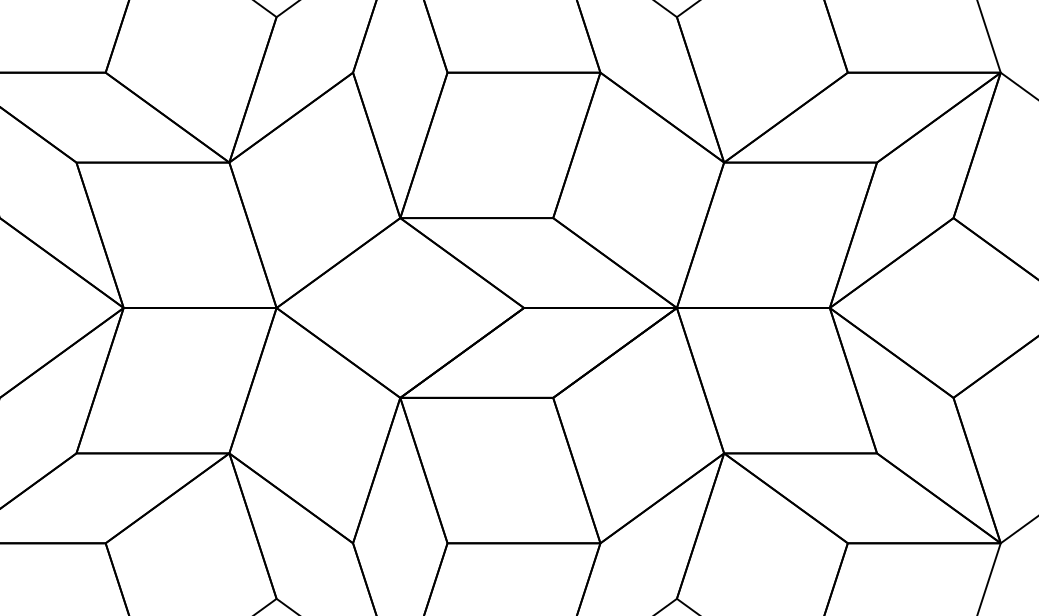

In [30]:
# Remove all tiles not inside the image boundary.
margin = 1.05
xbound = np.array([0, image.shape[1]])
ybound = np.array((0, image.shape[0]))

valid_tiles = list(filter(lambda t: is_in_box(t, xbound, ybound, margin), shift_tiles))
print(len(valid_tiles))
svg = make_svg(
    valid_tiles,
    stroke_width=stroke_width
)
write_svg(svg, Path("map_tiles.svg"))
show_svg(Path("map_tiles.svg"))

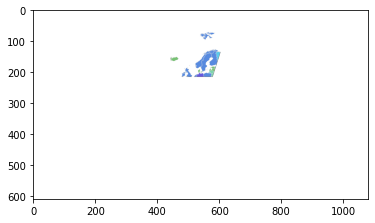

In [31]:
tile = valid_tiles[14]
pts = np.array([complex2cart(v) for v in tile], dtype=np.int32)

mask = np.zeros(image.shape, np.uint8)
mask=cv2.fillPoly(mask, [pts], (255,)*image.shape[2])
cv2.imwrite("mask.png", mask)

masked_image = cv2.bitwise_and(image, mask)

cv2.imwrite("masked.png", masked_image)
plt.imshow(masked_image)